# 모델 훈련 기초 (joint training)

## 데이터셋 다운로드

우선 데이터셋 다운로드부터 먼저 시작한다. 데이터셋은 미리 업로드된 구글 드라이브 링크로부터 다운로드하게 된다. 업로드된 파일을 내려받기 전에 프로젝트 디렉터리에 `data` 폴더가 있는지 검사하고 그 폴더 안에 각 데이터의 `.zip` 파일이 미리 받아졌는지 먼저 확인하고 (md5 해싱 이용) 파일이 문제가 없으면 압축을 푼다.

In [1]:
import os
import gdown
import hashlib
import zipfile

def get_hash(filename):
    with open(filename, "rb") as f:
        data = f.read()
        hash = hashlib.md5(data).hexdigest()
    
    return hash

data_info = {
    "cwru": {"link": "https://drive.google.com/uc?id=1JfnCzisg0wTSkWw_I5sNLcvQMD5mloJy",
             "hash": "a66d9ea53e5b9959829c1d1057abc377"},
    "mfpt": {"link": "https://drive.google.com/uc?id=1HDmX9-v8dV1-53nvM9lSDj-2-S2_Dss5",
             "hash": "fcf44622538307e33503cb7f24fd33d3"},
    "ottawa": {"link": "https://drive.google.com/uc?id=1WelJO5RMFwKoNdumhtW-__PC881fh4J_",
               "hash": "ca0142f52e950b5579985586a6acc96a"
    }
}

os.chdir(os.path.join(globals()['_dh'][0], ".."))

if not os.path.isdir("./data"):
    os.mkdir("./data")

for key in data_info:
    filename = f"./data/{key}.zip"
    if not os.path.isfile(filename):
        gdown.download(data_info[key]["link"], f"./data/{key}.zip")
    else:
        hash = get_hash(filename)
        if hash != data_info[key]["hash"]:
            os.remove(filename)
            gdown.download(data_info[key]["link"], f"./data/{key}.zip")

for key in data_info:
    filename = f"./data/{key}.zip"
    zipfile.ZipFile(filename).extractall("./data/")


## 데이터셋 빌딩 및 분할

그 후, dfb 패키지에 사전 정의된 모듈을 활용하여 데이터프레임을 만든다. 현재 dfb의 download 모듈에서는 CWRU, MFPT, Paderborn, Ottawa 데이터셋을 자동으로 판다스 데이터프레임으로 변환해주는 기능을 제공한다. CWRU, MFPT, Paderborn 같은 경우는 리눅스 시스템에서 가동하는 기준으로 데이터 홈페이지에서 각 파일을 자동으로 다운로드해서 데이터프레임을 빌딩하는 기능도 제공하지만 이 예제에서는 편의성을 위해 구글드라이브 다운로드를 이용했다. Ottawa 데이터셋은 데이터 소스에서 바로 다운로드하는 기능을 제공하지 않으니 구글드라이브 다운로드를 이용해야 한다.

### CWRU 데이터셋

CWRU 데이터셋은 Case Western Reserve University가 제공하는 데이터셋이다 [링크](https://engineering.case.edu/bearingdatacenter/download-data-file). 이 데이터셋은 12, 24 kHz의 sampling rate, 1, 2, 3, hp의 load에서 수집된 진동 데이터를 제공한다. 각 데이터는 정상, 내륜/외륜/볼 결함의 4종류에서 측정된 진동 데이터로 구성되어 있다. 각 결함은 데이터 생성자들이 인공적으로 만들었으며 0.007, 0.014, 0.021, 0.028 inch 크기 베어링에 대한 데이터를 제공한다. 본 예제에서는 sampling rate 12 kHz, 결함 크기 0.007, 0.014, 0.021 inch 데이터를 사용한다. CWRU 데이터셋의 더 자세한 내용은 프로젝트 디렉터리의 `Optimizer Benchmark.pdf`의 Section III-A나 [이 논문](https://ieeexplore.ieee.org/document/9078761)을 참조하면 좋다.

### MFPT 데이터셋

MFPT 데이터셋은 Society for Machinery Failure Prevention Technology에서 제공하는 데이터셋이다 [링크](https://www.mfpt.org/fault-data-sets/). 이 데이터셋은 CWRU보다 조금 더 다양한 load condition에서 측정된 데이터를 제공한다. 데이터는 정상, 내/외륜 결함의 3종류에서 측정되었다. MFPT 데이터셋의 상세사항 역시 프로젝트 디렉터리의 `Optimizer Benchmark.pdf`의 Section III-A나 [이 논문](https://ieeexplore.ieee.org/document/9078761)을 참조하면 좋다.

### Ottawa 데이터셋

Ottawa 데이터셋은 동적으로 변하는 회전기계 환경에서 수집된 베어링 진동 데이터셋이다 [링크](https://data.mendeley.com/datasets/v43hmbwxpm/2). 이 데이터셋은 측정 중 모터 회전속도가 동적으로 변하는 상황에서 측정되었따. 데이터는 정상, 볼/내륜/외륜 결함의 4종류뿐만 아니라 모든 부분에 손상이 가해진 데이터도 제공한다. 다만 후술할 continual learning 시나리오에 맞추기 위해서 본 예제에서는 정상, 내륜/외륜 결함의 3가지 데이터셋만 사용했다. 이 데이터셋에 대한 상세한 내용은 데이터 제공자의 [논문](https://www.sciencedirect.com/science/article/pii/S2352340918314124?ref=cra_js_challenge&fr=RR-1)을 참고하면 좋다.

### 데이터셋 분할

**중요 변경점: 데이터를 훈련, 검증, 테스트로 분리하기 이전에 먼저 빌딩하면 test 데이터 내용이 train으로 섞일 수 있어서 분할 방법을 변경함.**

데이터셋을 다운로드받은 후 각 데이터 세그먼트를 6:2:2 비율로 분할하여 train, validation, test 데이터셋으로 사용한다.

### 각 데이터를 분석해보는 방법

데이터를 분석하는 좋은 방법 중 하나는 수집된 진동 데이터를 `matplotlib`으로 시각화해보는 것이다. 다음의 구현을 통해 신호의 특성을 파악해볼 수 있다.

* Raw signal을 plt.plot으로 시각화해보기. 한 데이터의 길이가 너무 길다면 일부를 잘라서 확인해보는 것도 좋음. 이 신호를 눈으로 확인해 보면 각 fault별로 어떤 특징들이 있는지 1차적으로 간단히 파악 가능함.
* FFT 해보기: 각 신호의 주파수 성분 요소를 파악하기 위해 numpy같은 라이브러리에서 제공하는 FFT 함수를 통해 신호를 시각화해보면 신호가 가진 주요 주파수 대역을 알 수 있음. 조금 더 자세한 내용은 베어링 결함 진단 tutorial 논문인 FD_tutorial.pdf를 확인해보기
* 각 신호의 통계량 계산해보기: 각 신호의 RMS, peak, Crest Factor, Kurtosis 등의 통계량을 계산해볼 수 있음. 자세한 내용은 저장소의 Vibration Analysis.pdf를 확인해보기

In [2]:
from dfb.download import *
from dfb.databuilder import *

dfs = {}

train_dfs = {}
val_dfs = {}
test_dfs = {}

for key in data_info:
    dfs[key] = download_data(f"./data/{key}", key)

for key in data_info:
    train_dfs[key], val_dfs[key], test_dfs[key] = split_dataframe(dfs[key], 0.6, 0.2)

File is already existed, use existed file.


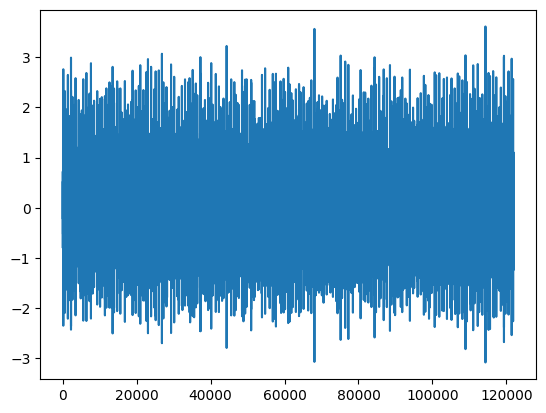

In [20]:
dfs["cwru"].iloc[15]["data"].shape
idx_start = 6000
plt.plot(x[idx_start:idx_start+4096])
#plt.plot(x)

(121991,)
IR


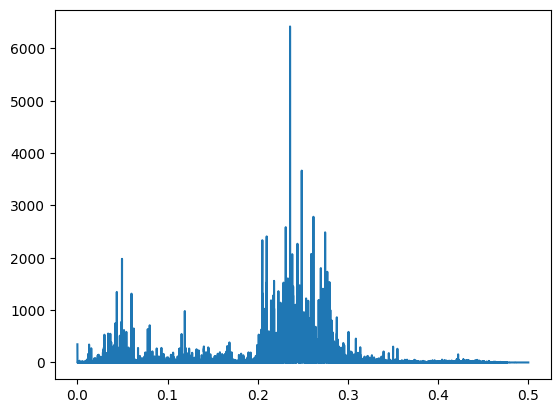

In [3]:
import matplotlib.pyplot as plt

data_idx = 15

x = dfs["cwru"].iloc[data_idx]["data"]
x_fft = np.fft.fft(x)
freq = np.fft.fftfreq(x.shape[-1])
idx_start = 6000

print(x.shape)
print(dfs["cwru"].iloc[data_idx].fault_type)
# plt.plot(x[idx_start:idx_start+4096])
# plt.plot(x)

plt.plot(freq[:x_fft.shape[0] // 2], np.abs(x_fft.real)[:x_fft.shape[0] // 2])

## Numpy Array 빌딩

데이터프레임을 생성하고 나서, continual learning에 쓰일 데이터셋을 만들 것이다. continual learning에 사용될 데이터는 experience로 나뉜다. 모델은 각 experience에 해당하는 데이터를 순차적으로 학습하면서, 이전 experience에 대한 정확도가 떨어지지 않고 전체 데이터에 대해 높은 정확도를 기록하는 것을 목표로 한다.

이 예제에서는 데이터프레임을 통해 level 1, 2, 3의 continual learning dataset을 만들 것이다. 데이터 level의 의미는 각 continual learning experience 간 데이터 도메인이 얼마나 크게 차이나는 지를 의미한다. 각 level은 다음과 같이 정의한다.

* `level 1`: 각 experience는 모두 CWRU 데이터셋으로 사용된다. experience A, B, C는 각각 1, 2, 3 hp의 load 환경에서 수집된 fault 데이터이다. load가 다른 데이터의 클래스를 판별하는 태스크의 난이도는 1 hp의 데이터셋만으로 훈련을 진행하여 2, 3 hp의 데이터셋을 90% 이상으로 판별할 수 있을 정도로 쉽기 때문에 level 1로 두었다.

* `level 2`: 각 experience는 모두 CWRU 데이터셋으로 사용된다. experience A, B, C는 각각 0.07, 0.14, 0.21 inch의 crack size에서 수집된 fault 데이터이다. 2022년 발표된 Hendricks et al.의 benchmark [연구](https://www.sciencedirect.com/science/article/pii/S0888327021010499)는 다른 load에서 수집된 데이터를 분류하는 태스크보다 다른 crack size에서 수집된 데이터를 분류하는 태스크의 정확도가 훨씬 낮다는 것을 보였다. 따라서 crack size가 다른 데이터가 추가로 들어오는 상황에서 학습을 진행하는 것을 level 2로 두었다. Healty bearing은 crack size가 없으므로 모든 experience에 일괄적으로 추가해 놓았다. 이 부분은 나중에 변경이 필요할 경우 변경하면 된다.

* `level 3`: 각 experience A, B, C의 데이터셋이 CWRU, MFPT, Ottawa University로 모두 다르다. 이 세 데이터셋은 모두 회전 기계의 bearing fault class를 가진 진동 데이터셋이지만 측정 조건이 완전히 다르다. 따라서 dataset level이 다른 데이터가 추가로 들어오는 상황에서 학습을 진행하는 것을 level 3으로 두었다.

데이터프레임은 databuilder 모듈의 `build_from_dataframe` 함수를 통해 numpy array로 변환된다. 이 함수에서 정하는 `sample_length`는 한 샘플의 데이터 길이를, `shift`는 데이터 세그멘트에서 샘플 데이터를 overlapping으로 추출할때의 shift size이다. 데이터를 추출하는 방법에 대한 자세한 설명은 내가 2022년에 쓴 논문 (프로젝트 디렉터리의 `Optimizer Benchmark.pdf`의 Section III-A의 Fig.3 참조)을 참조하면 된다.

코드에서 CWRU 데이터셋 데이터프레임에 label이 999인 row를 제외시키는 코드가 있다. 현재 코드에서 CWRU 레이블이 999로 처리된 부분은 예전 논문에서 실험할 때 사용하지 않았던 데이터들이다. 나중에 코드를 수정해서 갖다 써도 무방하다.

현재 구현되어 있는 모델의 input length의 최댓값이 4,096이라 `sample_length`는 기본적으로 4,096으로 두었다. 추후에 훈련을 진행할 때는 더 작은 길이의 샘플을 입력으로 받는 모델의 경우 샘플의 앞 부분만 잘라서 사용하면 된다.

CWRU, MFPT 데이터셋은 데이터셋의 규모가 비슷하지만, Ottawa 데이터셋은 앞의 두 데이터셋보다 크기가 10배 이상 크다. experience의 규모가 크게 달라지는 경우를 방지하기 위해 `level 3` 데이터셋을 구축할 때는 각 세그먼트에서 정해진 `N`개의 샘플만 랜덤으로 복원추출하는 bootstrap 방식을 사용해서 클래스별 샘플 수를 다른 level과 비슷하도록 맞췄다.

In [4]:
from dfb.databuilder import *

train_df_cwru = train_dfs["cwru"]
train_df_mfpt = train_dfs["mfpt"]
train_df_ottawa = train_dfs["ottawa"]

val_df_cwru = val_dfs["cwru"]
val_df_mfpt = val_dfs["mfpt"]
val_df_ottawa = val_dfs["ottawa"]

test_df_cwru = test_dfs["cwru"]
test_df_mfpt = test_dfs["mfpt"]
test_df_ottawa = test_dfs["ottawa"]

sample_length = 4096
shift = 2048

# level 1 데이터셋 제작

train_data_level1 = {}
val_data_level1 = {}
test_data_level1 = {}

def generate_level1(df, sample_length, shift):
    data = {}
    df_A = df[(df["load"] == 1) & (df["label"] != 999)]
    df_B = df[(df["load"] == 2) & (df["label"] != 999)]
    df_C = df[(df["load"] == 3) & (df["label"] != 999)]

    data["A"] = build_from_dataframe(df_A, sample_length=sample_length, shift=shift)
    data["B"] = build_from_dataframe(df_B, sample_length=sample_length, shift=shift)
    data["C"] = build_from_dataframe(df_C, sample_length=sample_length, shift=shift)

    return data

train_data_level1 = generate_level1(train_df_cwru, sample_length, shift)
val_data_level1 = generate_level1(val_df_cwru, sample_length, shift)
test_data_level1 = generate_level1(test_df_cwru, sample_length, shift)

# level 2 데이터셋 제작

def set_label_level2(row):
    label_map = {
        "N": 0,
        "B": 1,
        "IR": 2,
        "OR@06": 3
    }
    row["label"] = label_map[row["fault_type"]]
    return row

def generate_level2(df, sample_length, shift):
    data = {}
    df_normal = df[(df["fault_type"] == "N")]
    df_007 = df[(df["crack_size"] == "007") & (df["label"] != 999)]
    df_014 = df[(df["crack_size"] == "014") & (df["label"] != 999)]
    df_021 = df[(df["crack_size"] == "021") & (df["label"] != 999)]
    df_A = pd.concat(objs=(df_normal, df_007)).apply(set_label_level2, axis="columns")
    df_B = pd.concat(objs=(df_normal, df_014)).apply(set_label_level2, axis="columns")
    df_C = pd.concat(objs=(df_normal, df_021)).apply(set_label_level2, axis="columns")

    data["A"] = build_from_dataframe(df_A, sample_length=sample_length, shift=shift)
    data["B"] = build_from_dataframe(df_B, sample_length=sample_length, shift=shift)
    data["C"] = build_from_dataframe(df_C, sample_length=sample_length, shift=shift)

    return data

train_data_level2 = generate_level2(train_df_cwru, sample_length, shift)
val_data_level2 = generate_level2(val_df_cwru, sample_length, shift)
test_data_level2 = generate_level2(test_df_cwru, sample_length, shift)

# level 3 데이터셋 제작

data_level3 = {}

def set_label_level3(row):
    label_map = {
        "N": 0,
        "IR": 1,
        "OR@06": 2,
        "OR": 2
    }
    row["label"] = label_map[row["fault_type"]]
    return row

def generate_level3(df_cwru, df_mfpt, df_ottawa, sample_length, sample_ratio):
    sample_map = {
        "cwru": {
            "0": round(1*105*sample_ratio),
            "1": round(1*35*sample_ratio),
            "2": round(1*35*sample_ratio)
        },
        "mfpt": {
            "0": round(1*140*sample_ratio),
            "1": round(1*60*sample_ratio),
            "2": round(1*42*sample_ratio)
        },
        "ottawa": {
            "0": round(1*35*sample_ratio),
            "1": round(1*35*sample_ratio),
            "2": round(1*35*sample_ratio)
        }
    }
    data = {}

    filter_cwru = df_cwru[df_cwru["label"] != 999]
    filter_cwru = filter_cwru[(df_cwru["fault_type"] == "N") | (df_cwru["fault_type"] == "IR") | (df_cwru["fault_type"] == "OR@06")].reset_index(drop=True)
    filter_mfpt = df_mfpt[(df_mfpt["fault_type"] == "N") | (df_mfpt["fault_type"] == "IR") | (df_mfpt["fault_type"] == "OR")].reset_index(drop=True)
    filter_ottawa = df_ottawa[(df_ottawa["fault_type"] == "N") | (df_ottawa["fault_type"] == "IR") | (df_ottawa["fault_type"] == "OR")].reset_index(drop=True)

    filter_cwru = filter_cwru.apply(set_label_level3, axis="columns")
    filter_mfpt = filter_mfpt.apply(set_label_level3, axis="columns")
    filter_ottawa = filter_ottawa.apply(set_label_level3, axis="columns")

    data["A"] = bootstrap_from_dataframe(filter_cwru, sample_length=sample_length, n_sample=100, one_hot=False, n_map=sample_map["cwru"])
    data["B"] = bootstrap_from_dataframe(filter_mfpt, sample_length=sample_length, n_sample=100, one_hot=False, n_map=sample_map["mfpt"])
    data["C"] = bootstrap_from_dataframe(filter_ottawa, sample_length=sample_length, n_sample=100, one_hot=False, n_map=sample_map["ottawa"])

    return data

train_data_level3 = generate_level3(train_df_cwru, train_df_mfpt, train_df_ottawa, sample_length, 0.6)
val_data_level3 = generate_level3(val_df_cwru, val_df_mfpt, val_df_ottawa, sample_length, 0.2)
test_data_level3 = generate_level3(test_df_cwru, test_df_mfpt, test_df_ottawa, sample_length, 0.2)

/tmp/ipykernel_2727835/3446598653.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filter_cwru = filter_cwru[(df_cwru["fault_type"] == "N") | (df_cwru["fault_type"] == "IR") | (df_cwru["fault_type"] == "OR@06")].reset_index(drop=True)


## 데이터 합치기

이 튜토리얼에서는 Continual learning의 upper bound인 joint training, 즉 모든 experience의 데이터를 한번에 학습하는 케이스를 다룬다. 이를 통해 기본적인 모델의 성능을 평가하고, 그 후 continual learning 시나리오에 적용하는 스텝을 밟으면 된다.

In [5]:
# ====================== Level 1
X_train_1 = np.vstack(
    [train_data_level1["A"][0],
     train_data_level1["B"][0],
     train_data_level1["C"][0]]
)

y_train_1 = np.hstack(
    [train_data_level1["A"][1],
     train_data_level1["B"][1],
     train_data_level1["C"][1]]
)

X_val_1 = np.vstack(
    [val_data_level1["A"][0],
     val_data_level1["B"][0],
     val_data_level1["C"][0]]
)

y_val_1 = np.hstack(
    [val_data_level1["A"][1],
     val_data_level1["B"][1],
     val_data_level1["C"][1]]
)

X_test_1 = np.vstack(
    [test_data_level1["A"][0],
     test_data_level1["B"][0],
     test_data_level1["C"][0]]
)

y_test_1 = np.hstack(
    [test_data_level1["A"][1],
     test_data_level1["B"][1],
     test_data_level1["C"][1]]
)

# ====================== Level 2
X_train_2 = np.vstack(
    [train_data_level2["A"][0],
     train_data_level2["B"][0],
     train_data_level2["C"][0]]
)

y_train_2 = np.hstack(
    [train_data_level2["A"][1],
     train_data_level2["B"][1],
     train_data_level2["C"][1]]
)

X_val_2 = np.vstack(
    [val_data_level2["A"][0],
     val_data_level2["B"][0],
     val_data_level2["C"][0]]
)

y_val_2 = np.hstack(
    [val_data_level2["A"][1],
     val_data_level2["B"][1],
     val_data_level2["C"][1]]
)

X_test_2 = np.vstack(
    [test_data_level2["A"][0],
     test_data_level2["B"][0],
     test_data_level2["C"][0]]
)

y_test_2 = np.hstack(
    [test_data_level2["A"][1],
     test_data_level2["B"][1],
     test_data_level2["C"][1]]
)

# ====================== Level 3
X_train_3 = np.vstack(
    [train_data_level3["A"][0],
     train_data_level3["B"][0],
     train_data_level3["C"][0]]
)

y_train_3 = np.hstack(
    [train_data_level3["A"][1],
     train_data_level3["B"][1],
     train_data_level3["C"][1]]
)

X_val_3 = np.vstack(
    [val_data_level3["A"][0],
     val_data_level3["B"][0],
     val_data_level3["C"][0]]
)

y_val_3 = np.hstack(
    [val_data_level3["A"][1],
     val_data_level3["B"][1],
     val_data_level3["C"][1]]
)

X_test_3 = np.vstack(
    [test_data_level3["A"][0],
     test_data_level3["B"][0],
     test_data_level3["C"][0]]
)

y_test_3 = np.hstack(
    [test_data_level3["A"][1],
     test_data_level3["B"][1],
     test_data_level3["C"][1]]
)

In [6]:
print("LEVEL 1 ===")
print(X_train_1.shape, y_train_1.shape)
print(X_val_1.shape, y_val_1.shape)
print(X_test_1.shape, y_test_1.shape)

print("LEVEL 2 ===")
print(X_train_2.shape, y_train_2.shape)
print(X_val_2.shape, y_val_2.shape)
print(X_test_2.shape, y_test_2.shape)

print("LEVEL 3 ===")
print(X_train_3.shape, y_train_3.shape)
print(X_val_3.shape, y_val_3.shape)
print(X_test_3.shape, y_test_3.shape)

LEVEL 1 ===
(1341, 4096) (1341,)
(409, 4096) (409,)
(409, 4096) (409,)
LEVEL 2 ===
(2701, 4096) (2701,)
(841, 4096) (841,)
(841, 4096) (841,)
LEVEL 3 ===
(2266, 4096) (2266,)
(752, 4096) (752,)
(752, 4096) (752,)


## 데이터로더 래핑

numpy array를 PyTorch에서 사용가능한 데이터로더로 만들기 위해서는 추가로 모델 입력의 길이, 모델의 transform (데이터 전처리 함수), 배치 크기, num_worker가 필요하다. 모델 입력의 길이와 transform은 모델에 따라 달라진다. 현재 이 예제에서 구현되어 있는 모델의 입력 길이와 transform은 experiment 모듈의 get_sample_length와 get_transform을 통해 바로 가져올 수 있다. 그렇게 한 후에 dataset 모듈에서 제공하는 `DatasetHandler`클래스를 사용해서 각 level과 experience에 해당하는 numpy array를 `assign` 메소드를 통해 PyTorch 데이터로더로 변환하게 된다.

각 데이터는 `DatasetHandler`의 `dataloaders`멤버의 key에 접근하여 확인할 수 있고, 데이터로더는 `dataset`이라는 멤버를 가져서 그 멤버 안에서 개별 데이터를 확인할 수 있다.

이 부분을 이해하기 위해서는 다음과 같은 내용을 찾아보면 좋다.
* PyTorch는 훈련 데이터셋을 어떻게 다루는지? 이미지, numpy, 또는 Tensor 데이터에서 어떤 과정으로 `DataLoader`를 만드는지 PyTorch 공식 문서에서 확인해 볼것
* PyTorch는 개별 데이터를 transforms라는 모듈을 통해 전처리함. Raw 데이터는 모델에 훈련 입력으로 들어가기 전에 transforms의 규칙에 따라 전처리되게 됨. 이 부분을 PyTorch 공식 문서에서 확인해 볼 것.
* 미리 정의된 모델 및 transforms는 experiment.py 파일의 model_info 딕셔너리에 들어가 있음. 이걸 참고해서 어떤 방식으로 데이터가 전처리되는지 확인해 볼 것

In [7]:
from dfb.dataset import *
from dfb.processing import *
import experiment
import torchvision.transforms as transforms

model_name = "wdcnn"

sample_length = experiment.get_sample_length(model_name)
tf_data = experiment.get_transform(model_name)
tf_data = transforms.Compose(tf_data)
tf_label = NpToTensor()
batch_size = 128
num_worker = 4

data_handler = DatasetHandler()

# ============================== level 1

data_handler.assign(
    X_train_1, y_train_1, X_val_1, y_val_1, X_test_1, y_test_1,
    sample_length, "1", tf_data, tf_label, batch_size, num_worker
)

data_handler.assign(
    X_train_2, y_train_2, X_val_2, y_val_2, X_test_2, y_test_2,
    sample_length, "2", tf_data, tf_label, batch_size, num_worker
)

data_handler.assign(
    X_train_3, y_train_3, X_val_3, y_val_3, X_test_3, y_test_3,
    sample_length, "3", tf_data, tf_label, batch_size, num_worker
)

/data/home/happy113200/anaconda3/envs/cfb/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# 데이터로더 접근하기
data_handler.dataloaders["1"]["train"]

#데이터셋 접근하기
data_handler.dataloaders["1"]["train"].dataset

#원본 numpy array 접근하기
data_handler.dataloaders["1"]["train"].dataset[0]

(tensor([[ 0.0461, -0.0371, -0.0895,  ...,  0.0013, -0.0271, -0.0098]]),
 tensor(0))

## 모델 가져오기

모델은 아주 간단하게 가져올 수 있다. dfb의 model 폴더에 있는 모델을 아무거나 가져오면 된다. 해당 폴더 안에는 지금까지 구현했던 모델이 모두 들어있으며, 해당 모델에 대한 transforms와 sample_length는 위에서 설명했던 것과 같이 experiment.py 폴더의 model_info 딕셔너리에서 모두 얻을 수 있다. 이 단계에서 추후 확장성을 위해서는 PyTorch의 모델을 구현하는 능력이 있어야 한다.

In [9]:
# WDCNN 가져오기

from dfb.model.wdcnn import *
# 클래스 수는 맘대로 지정

# 클래스 수 10개짜리 모델 만들기
model = WDCNN(n_classes=3)

## 훈련하기

모델을 훈련하기 위해서는 다음과 같은 요소들이 필요하다.

* 데이터로더
* 모델
* 최적화 알고리즘
* 손실함수
* 훈련을 위한 정보: GPU 번호, 에포크

지금까지의 과정에서 데이터로더와 모델을 완성했다. 그리고 torch에서 제공하는 optimizer와 loss를 사용하면 되고, GPU 번호와 에포크는 사용자가 원하는 만큼 지정하면 된다. 이 튜토리얼에서의 훈련 과정에서는 PyTorch Lightning 라이브러리를 사용하여 훈련을 수행한다. PyTorch Lightning은 PyTorch의 high level 래퍼로, 훈련 코드를 간단하고 추상화된 형태로 만들어 준다. 이 튜토리얼에서는 직접 구현한 `PlModule` 클래스를 활용하여 훈련을 수행한다. 타고 들어가보면 PyTorch lightning에서 요구하는 형태의 순전파, 훈련스텝, 검증스텝, 로깅 등이 구현되어 있다. 이 코드를 이해하기 위해서는 PyTorch lightning의 코드에 대한 이해도가 있어야 되서 추가적인 공부가 필요하다.

추천하는 방법은 아래 마무리 부분에서 설명할 것처럼 이 튜토리얼의 모든 내용을 직접 만들어 보는 것이다. 맨 앞부분에서 numpy 데이터를 가져오는 부분까지만 사용한 후 그 다음 부분을 직접 구현해보면 살짝 감이 올 것이다.

In [10]:
from dfb.trainmodule import *

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()

# ticnn 플래그는 일단 신경쓸 필요 X
training_module = PlModule(model, optimizer, loss, True)

n_steps_d = len(data_handler.dataloaders["3"]["train"].dataset) // (batch_size)

# val_loss 가 가장 작은 모델을 저장하는 콜백
callback = pl.callbacks.ModelCheckpoint(monitor="val_loss",
                                        dirpath=f"./logs/test/best_model",
                                        filename=f"model",
                                        save_top_k=1,
                                        mode="min")
trainer = pl.Trainer(
    gpus = [0],
    max_epochs=10,
    val_check_interval= n_steps_d,
    default_root_dir="./logs/test",
    callbacks=[callback]
)

result = trainer.fit(model=training_module,
                     train_dataloaders=data_handler.dataloaders["3"]["train"],
                     val_dataloaders=data_handler.dataloaders["3"]["val"])


/data/home/happy113200/anaconda3/envs/cfb/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/home/happy113200/anaconda3/envs/cfb/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /data/home/happy113200/DeepFault/logs/test/best_model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | WDCNN            | 53.8 K
1 | loss_fn | CrossEntropyLoss |

/data/home/happy113200/anaconda3/envs/cfb/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  96%|█████████▌| 23/24 [00:01<00:00, 20.94it/s, loss=0.9, v_num=80]  

2023-08-24 07:33:08.416167: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 07:33:08.574500: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-24 07:33:09.325019: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64
2023-08-24 07:33:09.325119: W tensorflow/compiler/xla/strea

Epoch 9: 100%|██████████| 24/24 [00:01<00:00, 18.45it/s, loss=0.204, v_num=80, val_loss=0.189, val_acc=0.907, train_loss=0.202, train_acc=0.895]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 24/24 [00:01<00:00, 18.39it/s, loss=0.204, v_num=80, val_loss=0.189, val_acc=0.907, train_loss=0.202, train_acc=0.895]


### 테스트하기

훈련이 끝나면 val_loss가 가장 낮은 모델을 불러와서 테스트 데이터셋에 대해 테스트하면 된다.

In [11]:
training_module.load_from_checkpoint(f"./logs/test/best_model/model.ckpt",
                                            model=model, optimizer=optimizer,
                                            loss_fn=loss)
result = trainer.test(model=training_module, dataloaders=data_handler.dataloaders["3"]["test"])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 109.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9095744490623474
        test_loss           0.20495747029781342
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### 이제부터 해야될 것

이 튜토리얼은 베어링 결함 진단 과정이 어떻게 진행되는지 보여주고자 제작된 것이고, 대부분의 구현 및 훈련과정은 미리 모듈 형태로 구현된 소스코드를 사용한다. 따라서 이해를 높이기 위해 다음 스텝을 밟아서 추가적인 공부를 진행해봐야 한다.


* PyTorch 기반 훈련 프로세스 만들어보기: `PlMoudle`이 해주고 있는 훈련 프로세스를 PyTorch로 그대로 구현해 보자. 우선 PyTorch의 훈련 프로세스를 이해한 후에 PyTorch lightning으로 구현해보는 것을 추천한다.
* 모델 바꿔보기: 일단 현재 코드에서 모델을 다른 걸로 바꿔 본다. STFTCNN이나 STIMCNN은 2D CNN 계열의 모델로 전처리가 좀 더 복잡하다. 자세한 모델의 구조는 Optimizer Benchmark 논문을 확인해보자. 여러 모델을 돌려가면서 transforms에서 어떤 전처리가 일어나는지, 각 모델은 어떤 식으로 구현되어 있는지 공부를 해보는게 우선이다
* 모델 직접 구현해보기: 아주 간단한 1D나 2D CNN이라도 괜찮고 이미 있는 image classification 모델을 가져와도 괜찮다. 자유로운 방식으로 custom 모델과 transforms를 구현한 뒤에 검증해보는 것이 다음 단계이다.
* 데이터로더 만들기: PyTorch 공식 문서에서 `Dataset`, `DataLoader`를 공부한 뒤 직접 데이터 가져오는 부분을 구현해 보자. numpy array 형 데이터를 가져와 PyTorch에서 자유롭게 훈련할 수 있는 이해도가 되었다면 충분하다.
* 데이터 뜯어보기: 마지막 단계이다. 응용에 대한 이해도를 높이기 위해 위에서 잠깐 설명했던 것처럼 데이터를 시각화하거나 신호처리 해보면서 데이터를 뜯어보는게 목표이다.

위의 단계를 전부 수행하면 기본적으로 베어링 결함진단 코드를 작성하고 관련 논문의 구현요소를 이해하는 데는 어려움이 없어질 것으로 보인다.